In [25]:
import os
import s3fs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from math import log, floor

In [13]:
BUCKET_ID = Path('../bucket_id.txt').read_text().strip()
AWS_DEFAULT_REGION = 'us-west-2'

In [14]:
df = pd.read_csv(
    f"s3://dc-taxi-{BUCKET_ID}-{AWS_DEFAULT_REGION}/parquet/vacuum/.meta/stats/*"
)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   summary                             5 non-null      object 
 1   fareamount_double                   5 non-null      float64
 2   origin_block_latitude_double        5 non-null      float64
 3   origin_block_longitude_double       5 non-null      float64
 4   destination_block_latitude_double   5 non-null      float64
 5   destination_block_longitude_double  5 non-null      float64
 6   year_integer                        5 non-null      float64
 7   month_integer                       5 non-null      float64
 8   dow_integer                         5 non-null      float64
 9   hour_integer                        5 non-null      float64
dtypes: float64(9), object(1)
memory usage: 532.0+ bytes
None


In [15]:
summary_df = df.set_index('summary')
summary_df

,fareamount_double,origin_block_latitude_double,origin_block_longitude_double,destination_block_latitude_double,destination_block_longitude_double,year_integer,month_integer,dow_integer,hour_integer
summary,,,,,,,,,
count,1.426220e+07,1.426220e+07,1.426220e+07,1.426220e+07,1.426220e+07,1.426220e+07,1.426220e+07,1.426220e+07,1.426220e+07
mean,9.741264e+00,3.890459e+01,-7.703034e+01,3.890634e+01,-7.703004e+01,2.016624e+03,6.569351e+00,3.986920e+00,1.399724e+01
stddev,4.539085e+00,1.497835e-02,1.922855e-02,1.726343e-02,2.237168e-02,1.280343e+00,3.454275e+00,2.005323e+00,6.145545e+00
min,3.250000e+00,3.881206e+01,-7.711363e+01,3.881138e+01,-7.711363e+01,2.015000e+03,1.000000e+00,1.000000e+00,0.000000e+00
max,1.795600e+02,3.899422e+01,-7.691001e+01,3.899491e+01,-7.691001e+01,2.019000e+03,1.200000e+01,7.000000e+00,2.300000e+01


In [16]:
df_size = summary_df.loc['count'].astype(int).max()
print(df_size)

14262196


In [17]:
mu = summary_df.loc['mean']
print(mu)
sigma = summary_df.loc['stddev']
print(sigma)

fareamount_double                        9.741264
origin_block_latitude_double            38.904591
origin_block_longitude_double          -77.030336
destination_block_latitude_double       38.906345
destination_block_longitude_double     -77.030041
year_integer                          2016.624426
month_integer                            6.569351
dow_integer                              3.986920
hour_integer                            13.997240
Name: mean, dtype: float64
fareamount_double                     4.539085
origin_block_latitude_double          0.014978
origin_block_longitude_double         0.019229
destination_block_latitude_double     0.017263
destination_block_longitude_double    0.022372
year_integer                          1.280343
month_integer                         3.454275
dow_integer                           2.005323
hour_integer                          6.145545
Name: stddev, dtype: float64


# Choosing the Sample Size
We want to ensure that the test data set is large enough so that it is statistically similar to the entire dataset.

In [18]:
fractions = [.30, .15, .1, .01, .005]
print([df_size * fraction for fraction in fractions])

# in base 2 log scale
ranges = [floor(log(df_size * fraction, 2)) for fraction in fractions]
print(ranges)

[4278658.8, 2139329.4, 1426219.6, 142621.96, 71310.98]
[22, 21, 20, 17, 16]


In [19]:
sample_size_upper, sample_size_lower = max(ranges) + 1, min(ranges) - 1
print(sample_size_upper, sample_size_lower)

23 15


In [20]:
sizes = [2 ** i for i in range(sample_size_lower, sample_size_upper)]
fracs = [size / df_size for size in sizes]
print(*[(idx, sample_size_lower + idx, frac, size) for idx, (frac, size) in enumerate(zip(fracs, sizes))], sep=
'\n')

(0, 15, 0.0022975423980991427, 32768)
(1, 16, 0.004595084796198285, 65536)
(2, 17, 0.00919016959239657, 131072)
(3, 18, 0.01838033918479314, 262144)
(4, 19, 0.03676067836958628, 524288)
(5, 20, 0.07352135673917257, 1048576)
(6, 21, 0.14704271347834513, 2097152)
(7, 22, 0.29408542695669027, 4194304)


We next use standard error of the mean statistic along with diminishing returns (a marginal) to produce sample sizes for the test data set.

In [22]:
def sem(lower, upper, mu, sigma):
  sizes = pd.Series([
    2 ** i for i in range(lower, upper + 1)
  ])
  
  est_sem_df = pd.DataFrame(
    np.outer((1 / np.sqrt(sizes)), sigma.values),
    columns= sigma.index,
    index= sizes.values
  )
  
  return est_sem_df

sem_df = sem(sample_size_lower, sample_size_upper, mu, sigma)

([<matplotlib.axis.XTick at 0x1312c2cd0>,
 [Text(32768, 0, '2^15'),
  Text(65536, 0, '2^16'),
  Text(131072, 0, '2^17'),
  Text(262144, 0, '2^18'),
  Text(524288, 0, '2^19'),
  Text(1048576, 0, '2^20'),
  Text(2097152, 0, '2^21'),
  Text(4194304, 0, '2^22'),
  Text(8388608, 0, '2^23')])

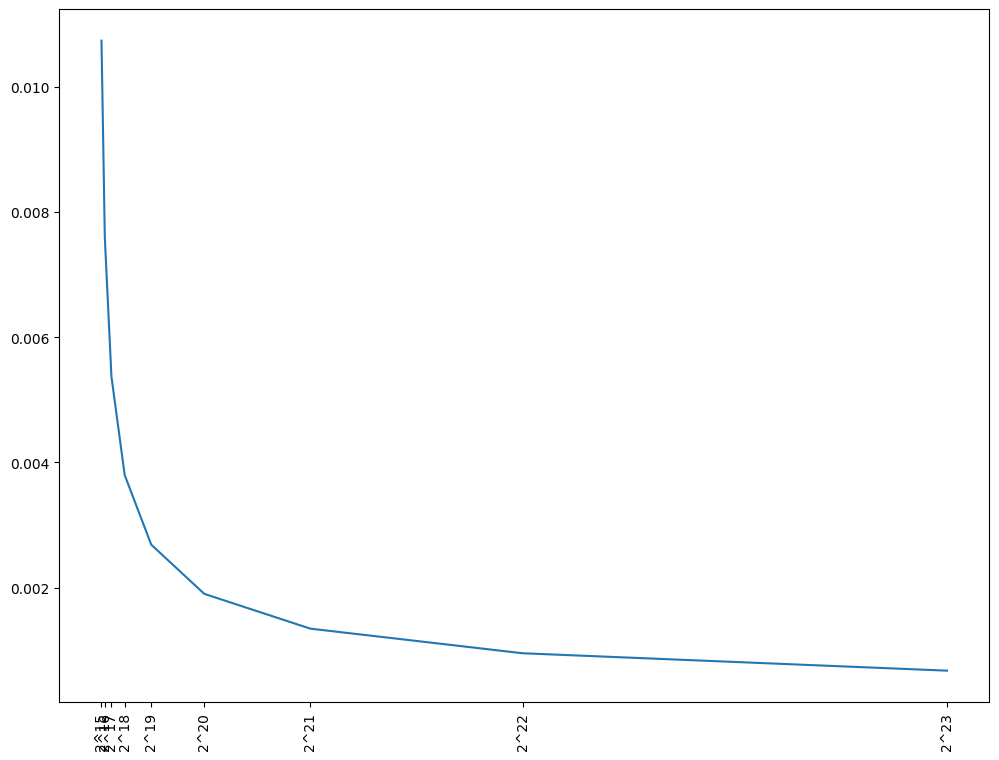

In [26]:
%matplotlib inline

plt.figure(figsize= (12, 9))
plt.plot(sem_df.index, sem_df.mean(axis = 1))
plt.xticks(sem_df.index,
           labels = list(map(lambda i: f"2^{i}", np.log2(sem_df.index.values).astype(int))),
           rotation= 90)

We see that although the sample size grows exponentially, the slope of the average SEM flattens with every doubling. We want to find a sample size such that if it were any larger, the improvements to the sem would yield diminishing returns. To identify the point of diminishing returns (marginal) we look at the total reduciton in the SEM for each increase in the sample size.

([<matplotlib.axis.XTick at 0x1333cbd10>,
 [Text(32768, 0, '2^15'),
  Text(65536, 0, '2^16'),
  Text(131072, 0, '2^17'),
  Text(262144, 0, '2^18'),
  Text(524288, 0, '2^19'),
  Text(1048576, 0, '2^20'),
  Text(2097152, 0, '2^21'),
  Text(4194304, 0, '2^22'),
  Text(8388608, 0, '2^23')])

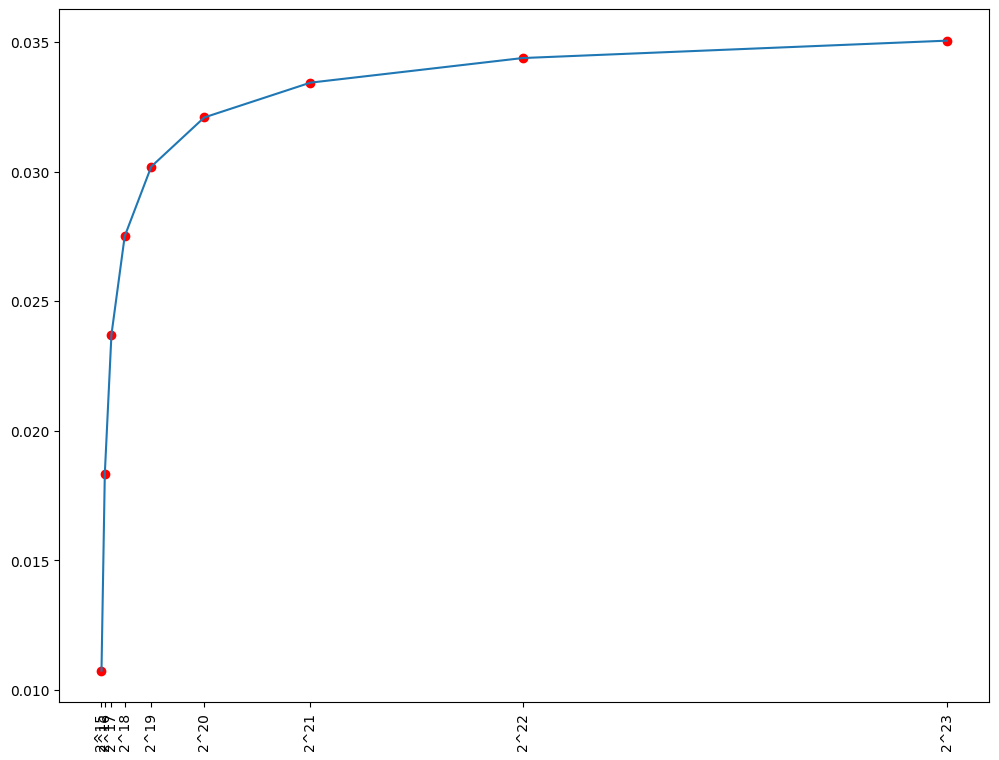

In [31]:
agg_change = sem_df.cumsum().mean(axis =1)

plt.figure(figsize= (12, 9))
plt.plot(sem_df.index, agg_change)
plt.scatter(sem_df.index, agg_change, color='red')
plt.xticks(sem_df.index,
           labels = list(map(lambda i: f"2^{i}", np.log2(sem_df.index.values).astype(int))),
           rotation= 90)

In [40]:
def marginal(x):
  coor = np.vstack([x.index.values, x.values]).transpose()
  return pd.Series(
    index = x.index, 
    data = np.cross(coor[-1] - coor[0], coor[-1] - coor) / np.linalg.norm(coor[-1] - coor[0])
    ).idxmin()

sample_size = marginal(agg_change)
print(sample_size, sample_size/df_size)

1048576 0.07352135673917257


The marginal test sample size chosen by the diminishing returns heuristic corresponds to 7% of the dataset. However, the SEM measure is designed to identify a **lower** bound for the sample size and does not indicate if the size is the right one to use for the test dataset.